In [9]:
import pandas as pd
import numpy as np
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import math
import torch
import unicodedata
import PLEARN_phono_helper
import imp
import glob
import os
from joblib import Parallel, delayed
imp.reload(PLEARN_phono_helper)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


<module 'PLEARN_phono_helper' from '/home/stephan/notebooks/child-directed-listening/PLEARN_phono_helper.py'>

In [10]:
xml_path =  '/shared_hd0/corpora/phonbank/Providence/Alex/020326.xml'

test = PLEARN_phono_helper.getArticulationProp(xml_path)

Processing /shared_hd0/corpora/phonbank/Providence/Alex/020326.xml...


/home/stephan/notebooks/child-directed-listening/PLEARN_phono_helper.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  citation_form_requires['age'] = getAgeFromDatestr(root.find(".//*[@id='CHI']/age").text ,'bmw')
/home/stephan/notebooks/child-directed-listening/PLEARN_phono_helper.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  citation_form_requires['xml_path'] = os.path.basename(xml_path)
/home/stephan/notebooks/child-directed-listening/PLEARN_phono_helper.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [11]:
test.head()

,word_gloss,actual,model,preceding_gloss,transcribed_model_length_mismatch,spk,gloss,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path
0,cars,ˈkɑːs,ˈkɑɹz,[],False,CHI,cars yyy,3,True,True,850.0,Alex,020326.xml
0,please,ˈpʌlɪ,ˈpliːz,[],False,CHI,please,15,True,False,850.0,Alex,020326.xml
0,please,ˈpʰlɪs,ˈpliːz,[],False,CHI,please,16,True,True,850.0,Alex,020326.xml
0,please,pəˈlis,ˈpliːz,[],False,CHI,please,22,True,True,850.0,Alex,020326.xml
0,please,ˈplis,ˈpliːz,[],False,CHI,please,29,True,True,850.0,Alex,020326.xml


In [12]:
transcript_paths = []
# excluding ComptonPater b/c diary study doesn't have tokens
# excluding StanfordEnglish b/c ages are not in an interpretable format
for corpus in ['Providence']:    
    transcript_paths.append(glob.glob('/shared_hd0/corpora/phonbank/'+corpus+'/**/*.xml'))
transcript_paths = [item for sublist in transcript_paths for item in sublist]
len(transcript_paths)

364

In [13]:
transcript_paths[1:5]

['/shared_hd0/corpora/phonbank/Providence/Alex/010614.xml',
 '/shared_hd0/corpora/phonbank/Providence/Alex/010512.xml',
 '/shared_hd0/corpora/phonbank/Providence/Alex/020300.xml',
 '/shared_hd0/corpora/phonbank/Providence/Alex/030200.xml']

In [14]:
# process the phonemic transcripts and save them to a pickle

regenerate = True
parallel = True

imp.reload(PLEARN_phono_helper)
if regenerate:
    if parallel:
        phono_token_dfs = Parallel(n_jobs=os.cpu_count())(delayed(PLEARN_phono_helper.getArticulationProp)(x) for x in transcript_paths)
    else:
        phono_token_dfs = [PLEARN_phono_helper.getArticulationProp(x) for x in transcript_paths]
    phono_token_df = pd.concat([x for x in phono_token_dfs if x is not None])
    phono_token_df.to_pickle('pkl/providence_phono.pkl')
else:
    phono_token_df = pd.read_pickle('pkl/providence_phono.pkl')

In [15]:
phono_token_df.shape

(49792, 13)

In [16]:
phono_token_df.iloc[0]

word_gloss                                  six
actual                                     ˈkik
model                                     ˈsɪks
preceding_gloss                              []
transcribed_model_length_mismatch         False
spk                                         CHI
gloss                                       six
utt_index                                   143
citation_form_requires                     True
actual_form_sz                                0
age                                         677
child                                      Alex
xml_path                             011006.xml
Name: 0, dtype: object

In [17]:
phono_token_df_short = phono_token_df[['child','age','actual_form_sz',
    'gloss']]

In [18]:
%R -i  phono_token_df_short

In [19]:
%%R 
phono_token_df_short$before24 = (phono_token_df_short$age / 30.5)  < 24
phono_token_df_short$before18 = (phono_token_df_short$age / 30.5)  < 18


In [20]:
%%R
aggregate(age ~ child + before24, phono_token_df_short, length)

     child before24   age
1     Alex    FALSE  6433
2    Ethan    FALSE  3070
3     Lily    FALSE 10422
4    Naima    FALSE 12560
5   Violet    FALSE  3934
6  William    FALSE  3858
7     Alex     TRUE   472
8    Ethan     TRUE  1453
9     Lily     TRUE   926
10   Naima     TRUE  5900
11  Violet     TRUE   415
12 William     TRUE   349


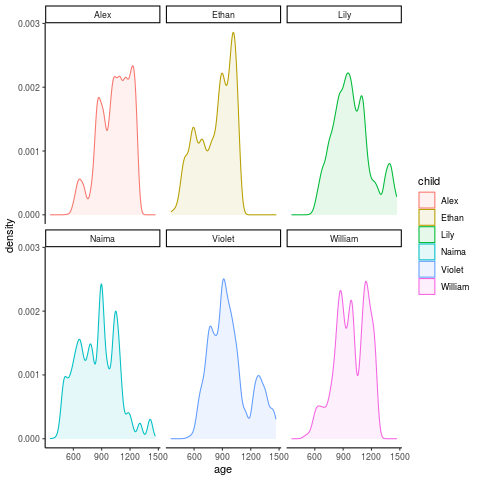

In [21]:
%%R
ggplot(phono_token_df_short) +geom_density(aes(x = age, color=child, fill=child), alpha=.1
) + facet_wrap(~child) + theme_classic()

In [22]:
%%R
library(lme4)
phono_token_df_short$before24_numeric = -1
phono_token_df_short$before24_numeric[phono_token_df_short$before24] = 1
m1 <- glmer(
  actual_form_sz ~ before24_numeric + (before24_numeric | child), 
  data = phono_token_df_short, 
  family = binomial(link = "logit")
)
summary(m1)

/home/stephan/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: actual_form_sz ~ before24_numeric + (before24_numeric | child)
   Data: phono_token_df_short

     AIC      BIC   logLik deviance df.resid 
 42069.4  42113.5 -21029.7  42059.4    49787 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4251  0.2920  0.4155  0.4644  0.7603 

Random effects:
 Groups Name             Variance Std.Dev. Corr
 child  (Intercept)      0.19028  0.4362       
        before24_numeric 0.03392  0.1842   0.57
Number of obs: 49792, groups:  child, 6

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       1.45569    0.16375   8.890  < 2e-16 ***
before24_numeric -0.25285    0.07563  -3.343 0.000828 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
befr24_nmrc 0.531 


In [23]:
%%R
inv_logit = function(x){exp(x)/(1+exp(x))}
print(inv_logit(1.56 +.25))
print(inv_logit(1.56 -.25))

[1] 0.8593619
[1] 0.7875132


In [24]:
counts_and_means = phono_token_df.groupby(['child','age']).actual_form_sz.aggregate( \
{'p_articulation':np.mean, 'num_tokens':np.size}).reset_index()
counts_and_means['age_in_months'] = counts_and_means['age'] / 30.5
%R -i counts_and_means

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [25]:
%%R
total_counts = aggregate(num_tokens ~ child, counts_and_means, sum)
names(total_counts) = c('child','child_num_tokens') 
print(total_counts)
print(sum(total_counts$child_num_tokens))
counts_and_means = merge(counts_and_means, total_counts)
counts_and_means$child_label = paste(counts_and_means$child, ' (n =', format(
    counts_and_means$child_num_tokens, big.mark=','), ')', sep='')

    child child_num_tokens
1    Alex             6905
2   Ethan             4523
3    Lily            11348
4   Naima            18460
5  Violet             4349
6 William             4207
[1] 49792


/home/stephan/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Saving 11.1 x 8.33 in image

  warnings.warn(x, RRuntimeWarning)
/home/stephan/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: `geom_smooth()` using method = 'loess' and formula 'y ~ x'

  warnings.warn(x, RRuntimeWarning)


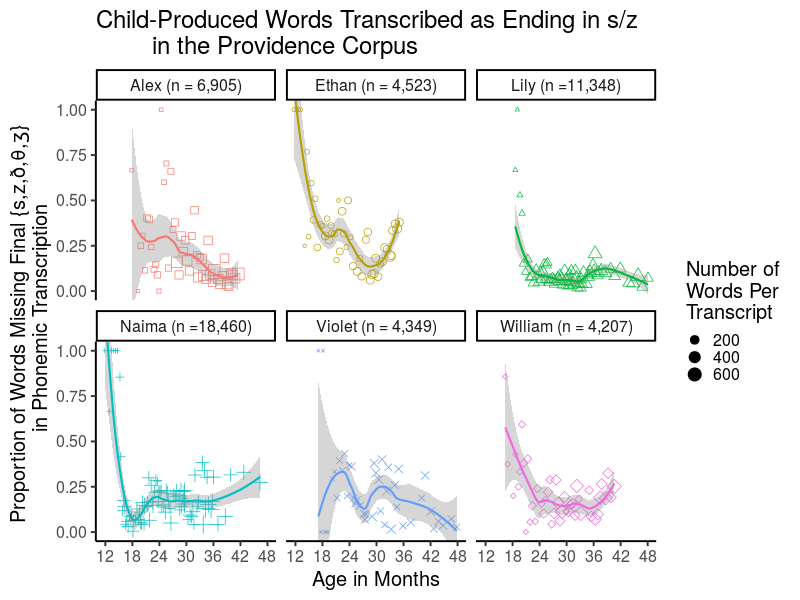

In [26]:
%%R -w 800 -h 600
p1 = ggplot(counts_and_means) + geom_point(aes(x=age_in_months, shape =child, colour=child,
y=1-p_articulation, size=num_tokens)) + scale_shape_manual(values=seq(0,15)
) + facet_wrap(~child_label) + geom_smooth(aes(x=age_in_months, y= 1-p_articulation, weight=num_tokens, colour=child),
span =1/2, show.legend = F) + coord_cartesian(ylim=c(0,1)) + ylab(
    'Proportion of Words Missing Final {s,z,ð,θ,ʒ} \n in Phonemic Transcription'
) + xlab('Age in Months') + theme_classic(base_size=20) + scale_x_continuous(breaks=seq(
    from=12, to=48, by=6)) + ggtitle('Child-Produced Words Transcribed as Ending in s/z 
\tin the Providence Corpus') + guides(colour=F, shape=F) + labs(size = "Number of\nWords Per\nTranscript")

ggsave('figures/elision_prevalence.png')
ggsave('figures/elision_prevalence.pdf')
print(p1)

In [27]:
phono_token_df.loc[(phono_token_df.child =='Naima') & (phono_token_df.age > 1250)]

,word_gloss,actual,model,preceding_gloss,transcribed_model_length_mismatch,spk,gloss,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path
0,Daddy's,ˈdeɪθk,ˈdædiːz,[],False,CHI,Daddy's gonna give me the yyy and you be the s...,2,True,1.0,1413.0,Naima,031010.xml
12,please,ˈpli,ˈpliːz,"[Daddy's, gonna, give, me, the, yyy, and, you,...",False,CHI,Daddy's gonna give me the yyy and you be the s...,2,True,0.0,1413.0,Naima,031010.xml
2,this,ˈðɪθ,ˈðɪs,"[no, like]",False,CHI,no like this,26,True,1.0,1413.0,Naima,031010.xml
1,Daddy's,ˈdæɪð,ˈdædiːz,[no],False,CHI,no Daddy's gonna be the customer and you're go...,38,True,1.0,1413.0,Naima,031010.xml
2,things,ˈθɪð,ˈθɪŋz,"[give, me]",False,CHI,give me things that we don't want,40,True,1.0,1413.0,Naima,031010.xml
1,goes,ˈɡʊð,ˈɡoʊz,[it],False,CHI,it goes to the receipt roll,47,True,1.0,1413.0,Naima,031010.xml
5,the,də,ˈwɛɹz,"[go, to, the, cash+register, where's]",False,CHI,go to the cash+register where's the xxx,52,True,0.0,1413.0,Naima,031010.xml
0,yes,ˈjɛs,ˈjɛs,[],False,CHI,yes we can,59,True,1.0,1413.0,Naima,031010.xml
3,this,ˈðis,ˈðɪs,"[you, can, pull]",False,CHI,you can pull this way,61,True,1.0,1413.0,Naima,031010.xml
0,this,ˈðɪs,ˈðɪs,[],False,CHI,this way,66,True,1.0,1413.0,Naima,031010.xml


In [28]:
# Ethan over 925
phono_token_df.loc[(phono_token_df.child =='Ethan') & (phono_token_df.age > 925)]

,word_gloss,actual,model,preceding_gloss,transcribed_model_length_mismatch,spk,gloss,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path
1,he's,ˈiðduwɪnə,ˈhiːz,[yyy],False,CHI,yyy he's doing a yyy yyy yyy,33,True,1.0,1026.0,Ethan,020920.xml
1,is,ˈɪð,ˈɪz,[one],False,CHI,one is a<n> airplane one is helicopter,47,True,1.0,1026.0,Ethan,020920.xml
5,is,ðɪ,ˈɪz,"[one, is, a<n>, airplane, one]",False,CHI,one is a<n> airplane one is helicopter,47,True,0.0,1026.0,Ethan,020920.xml
0,that's,ˈdæs,ˈðæts,[],False,CHI,that's a good name,61,True,1.0,1026.0,Ethan,020920.xml
0,that's,ˈðætʰ,ˈðæts,[],False,CHI,that's the red and blue one,74,True,1.0,1026.0,Ethan,020920.xml
2,both,ˈbuf,ˈboʊθ,"[they, did]",False,CHI,they did both,89,True,0.0,1026.0,Ethan,020920.xml
1,both,ˈbofə,ˈboʊθ,[yyy],False,CHI,yyy both but he has no wings,91,True,0.0,1026.0,Ethan,020920.xml
4,has,hæz,ˈhæz,"[yyy, both, but, he]",False,CHI,yyy both but he has no wings,91,True,1.0,1026.0,Ethan,020920.xml
6,wings,nwɪ,ˈwɪŋz,"[yyy, both, but, he, has, no]",False,CHI,yyy both but he has no wings,91,True,0.0,1026.0,Ethan,020920.xml
2,does,ˈdʌz,ˈdʌz,"[but, he]",False,CHI,but he does have wings,94,True,1.0,1026.0,Ethan,020920.xml


/home/stephan/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: `geom_smooth()` using method = 'loess' and formula 'y ~ x'

  warnings.warn(x, RRuntimeWarning)


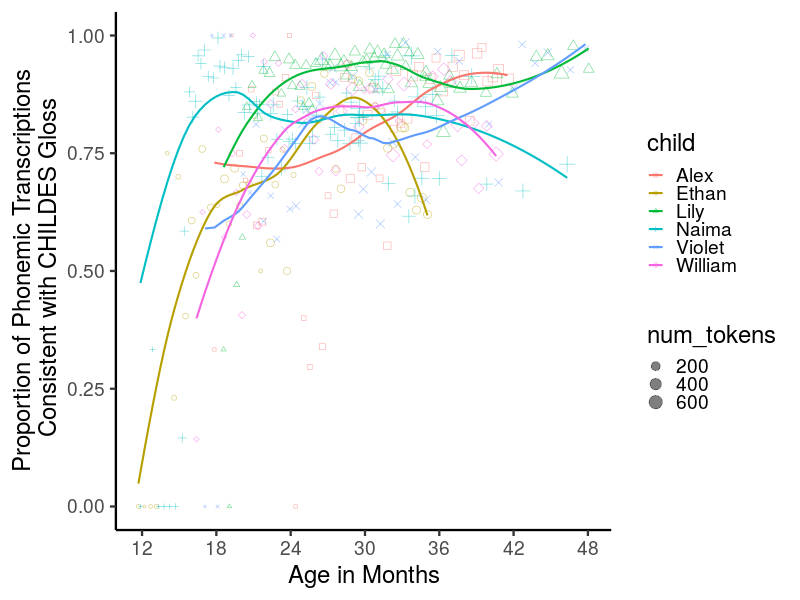

In [29]:
%%R -w 800 -h 600
ggplot(counts_and_means) + geom_point(aes(x=age_in_months, 
y=p_articulation, colour=child, shape=child, size=num_tokens), alpha =.5
) +  scale_shape_manual(values=seq(0,15))  + geom_smooth(aes(x=age_in_months, y= p_articulation,
weight=num_tokens, colour=child), se=F,
span =2/3) + coord_cartesian(ylim=c(0,1)) + theme_classic(base_size =24
) + ylab('Proportion of Phonemic Transcriptions\n Consistent with CHILDES Gloss'
) + xlab('Age in Months')  + scale_x_continuous(breaks=seq(from=12, to=48, by=6))

/home/stephan/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Saving 11.1 x 8.33 in image

  warnings.warn(x, RRuntimeWarning)


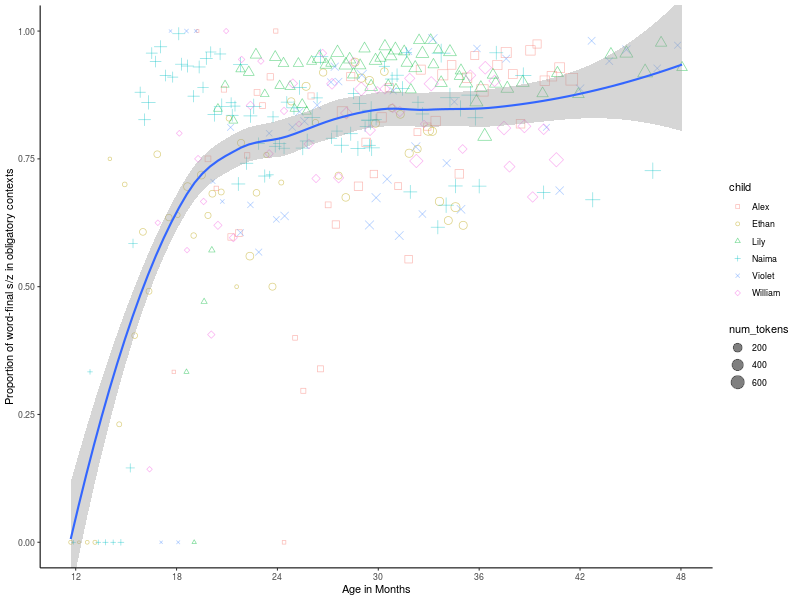

In [30]:
%%R -w 800 -h 600
p1 = ggplot(counts_and_means) + geom_point(aes(x=age_in_months, 
y=p_articulation, colour=child, shape=child, size=num_tokens), alpha =.5
)  +  scale_shape_manual(values=seq(0,15)) + geom_smooth(aes(x=age_in_months, 
y= p_articulation), se=T,span =2/3, ) + coord_cartesian(ylim=c(0,1)
) + theme_classic(
) + ylab('Proportion of word-final s/z in obligatory contexts'
) + xlab('Age in Months') + scale_x_continuous(breaks=seq(from=12, to=48, by=6))

ggsave('figures/p_articulation_across_children.pdf')

print(p1)

In [35]:
%%R
# get p_art from the above for every day, 1:365*4
query_ages_in_days = seq(0, (365*10))
query_ages_in_months = query_ages_in_days / 30.5

art.lo <- loess(p_articulation ~ age_in_months, counts_and_means,
    control = loess.control(surface = "direct"))
predicted = predict(art.lo, data.frame(age_in_months = query_ages_in_months), se = TRUE)
df = data.frame(age_in_days = query_ages_in_days, p_art = predicted$fit)
df$p_art[df$p_art < 0] = 0
write.csv(df,'csv/articulation_curve.csv', row.names=F)

It is not clear from the database manual, or from Song et al. 2009, what the convention was for the model-based transcription in the Providence corpus. For examples where the child uses an apparent singular form when the gloss is plural, where does this come from?

In [36]:
phono_token_df.to_csv('csv/phono_token_df.csv')

In [164]:
phono_token_df['id'] = range(phono_token_df.shape[0])

# Probability of Gloss vs. Transcript under an Adult Language Model

In [37]:
# identify instances of annotator-recovery from above 
# check if the production is in the dictionary, unk token if not

In [165]:
annotator_recovered_tokens = phono_token_df.loc[phono_token_df.actual_form_sz == 0]
annotator_recovered_tokens.shape

(7806, 14)

In [166]:
annotator_recovered_tokens.head(100)

,word_gloss,actual,model,preceding_gloss,transcribed_model_length_mismatch,spk,gloss,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path,id
0,six,ˈkik,ˈsɪks,[],False,CHI,six,143,True,0.0,677.0,Alex,011006.xml,0
0,what's,wə,ˈwʌts,[],False,CHI,what's that,364,True,0.0,677.0,Alex,011006.xml,3
0,six,ˈɪː,ˈsɪks,[],False,CHI,six,394,True,0.0,677.0,Alex,011006.xml,4
3,this,ˈoˈno,ˈðɪs,"[oh, no, what's]",False,CHI,oh no what's this oh no,468,True,0.0,677.0,Alex,011006.xml,6
1,this,,ˈðɪs,[what's],False,CHI,what's this,962,True,0.0,677.0,Alex,011006.xml,12
0,six,kɪːk,ˈsɪks,[],False,CHI,six,965,True,0.0,677.0,Alex,011006.xml,13
2,what's,,ˈwʌts,"[what's, that]",False,CHI,what's that what's that,1135,True,0.0,677.0,Alex,011006.xml,20
2,what's,,ˈwʌts,"[what's, that]",False,CHI,what's that what's,1143,True,0.0,677.0,Alex,011006.xml,22
4,what's,,ˈwʌts,"[what's, that, what's, that]",False,CHI,what's that what's that what's,1147,True,0.0,677.0,Alex,011006.xml,25
0,where's,ˈwɪ,ˈwɛɹz,[],False,CHI,where's the red,189,True,0.0,824.0,Alex,020300.xml,46


In [40]:
# Need a pronunciation dictionary. Start with https://github.com/menelik3/cmudict-ipa 

In [167]:
cmu_dict = pd.read_csv('/home/stephan/python/cmudict-ipa/cmudict-0.7b-ipa.txt',
    sep='\t', lineterminator='\r', header=None)
cmu_dict.columns = ['ortho','ipa']

print(cmu_dict.shape)
print(cmu_dict.head(5))

(125075, 2)
                ortho                   ipa
0  !EXCLAMATION-POINT  ˌɛkskləˈmeɪʃənˌpɔɪnt
1      \n"CLOSE-QUOTE          ˈkloʊzˈkwoʊt
2     \n"DOUBLE-QUOTE          ˈdʌbəlˈkwoʊt
3     \n"END-OF-QUOTE          ˈɛndəvˈkwoʊt
4        \n"END-QUOTE            ˈɛndˈkwoʊt


In [42]:
#make this longform, clean the contents
def expand_cmu_dict(cmu_record):
    ipa_split = [clean_cmu(x) for x in str(cmu_record['ipa']).split(', ')]
    rdf = pd.DataFrame({'ipa':ipa_split})
    rdf['ortho'] = cmu_record['ortho'].replace('\n','').lower()
    return(rdf)
    
def clean_cmu(cmu_pronunciation):
    # not clearn what cleaning is necessary    
    return(unicodedata.normalize('NFC', cmu_pronunciation))

cmu_dict_long = pd.concat([expand_cmu_dict(x) for x in cmu_dict.to_dict('records')])

In [43]:
cmu_dict_long.loc[cmu_dict_long.ortho == 'juice']

,ipa,ortho
0,ˈdʒuːs,juice


In [168]:
annotator_recovered_tokens.head()

,word_gloss,actual,model,preceding_gloss,transcribed_model_length_mismatch,spk,gloss,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path,id
0,six,ˈkik,ˈsɪks,[],False,CHI,six,143,True,0.0,677.0,Alex,011006.xml,0
0,what's,wə,ˈwʌts,[],False,CHI,what's that,364,True,0.0,677.0,Alex,011006.xml,3
0,six,ˈɪː,ˈsɪks,[],False,CHI,six,394,True,0.0,677.0,Alex,011006.xml,4
3,this,ˈoˈno,ˈðɪs,"[oh, no, what's]",False,CHI,oh no what's this oh no,468,True,0.0,677.0,Alex,011006.xml,6
1,this,,ˈðɪs,[what's],False,CHI,what's this,962,True,0.0,677.0,Alex,011006.xml,12


In [169]:
cmu_dict_long['ipa']

0    ˌɛkskləˈmeɪʃənˌpɔɪnt
0            ˈkloʊzˈkwoʊt
0            ˈdʌbəlˈkwoʊt
0            ˈɛndəvˈkwoʊt
0              ˈɛndˈkwoʊt
0              ˈɪnˈkwoʊts
0                  ˈkwoʊt
0               ˈʌnˈkwoʊt
0               ˈhæˌmɑːrk
0             ˈpaʊndˌsaɪn
0             ˈʃɑːrpˌsaɪn
0                 pɝˈsɛnt
0              ˈæmpɝˌsænd
0                 ˌɑːˈloʊ
0             əˈpɑːstrəfi
0                   ˈbaʊt
0                     kəz
0                   ˈkɔrs
0                  ˈkjuːz
0                      əm
0          ˈɛnˈdɪnɝˈkwoʊt
0              ˈɛndˈkwoʊt
0                ˈfrɪskoʊ
0                    ˈgɛn
0              ˈɪnɝˈkwoʊt
0                    ˈkeɪ
0                      əm
0                      ən
0                  ˈkwoʊt
0                  ˈraʊnd
             ...         
0                zˈwiːbəl
0          zˈwiːfəlˌhɑːfɝ
0                  zˈwiːg
0                 zˈwɪlɪŋ
0              zvəˈlɪnski
0                 ˈzɪˌkæd
0                  ˈzaɪtʃ
0           

In [170]:
"ˈsɪks" in set(cmu_dict_long['ipa'])

True

In [171]:
"ˈkɪks" in set(cmu_dict_long['ipa'])

True

In [172]:
# Need broad coverage among the model annotations
ipa_set = set(cmu_dict_long['ipa']).union(set([x.replace('r','ɹ') for x in \
    cmu_dict_long['ipa']])).union(set([x.replace('ɑː','ɑ') for x in \
    cmu_dict_long['ipa']])).union(set([x.replace('ɑː','ɑ').replace('r','ɹ') for x in \
    cmu_dict_long['ipa']]))
print(len(ipa_set))

def normalize_pvd(pvd_str):
    pvd_str = pvd_str.replace('ɡ','g') #unicode 609 latin g, damn it
    pvd_str = pvd_str.replace('ʧ','tʃ')
    pvd_str = pvd_str.replace('ʤ','dʒ')
    #pvd_str = pvd_str.replace('ː','') #vowel length markers removed after ICIS submission
    return(unicodedata.normalize('NFC', pvd_str))

annotator_recovered_tokens['model_normalized'] = [ normalize_pvd(x) \
    for x in annotator_recovered_tokens.model]
annotator_recovered_tokens['actual_normalized'] = [ normalize_pvd(x) \
    for x in annotator_recovered_tokens.actual]
annotator_recovered_tokens['model_in_cmu'] = [x in ipa_set for x in 
    annotator_recovered_tokens.model_normalized]
annotator_recovered_tokens['actual_in_cmu'] = [x in ipa_set for x in 
    annotator_recovered_tokens.actual_normalized]
print('Proportion of Actual Phonemeic Transcriptions in CMU Dict')
print(np.mean(annotator_recovered_tokens['actual_in_cmu']))
print('Proportion of Model Phonemic Transcriptions ("recovered tokens") in CMU Dict')
print(np.mean(annotator_recovered_tokens['model_in_cmu']))

183024


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

Proportion of Actual Phonemeic Transcriptions in CMU Dict
0.21086343838073277
Proportion of Model Phonemic Transcriptions ("recovered tokens") in CMU Dict
0.9355623879067384


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [173]:
annotator_recovered_tokens.loc[annotator_recovered_tokens.model == "ˈhiːz"]

,word_gloss,actual,model,preceding_gloss,transcribed_model_length_mismatch,spk,gloss,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path,id,model_normalized,actual_normalized,model_in_cmu,actual_in_cmu
0,he's,mi,ˈhiːz,[],False,CHI,he's sleeping,966,True,0.0,1076.0,Alex,021108.xml,5792,ˈhiːz,mi,True,False
8,he's,ˈhiː,ˈhiːz,"[Thomas, the, tank, engine, xxx, he's, the, one]",False,CHI,Thomas the tank engine xxx he's the one he's the,732,True,0.0,694.0,Ethan,011023.xml,7030,ˈhiːz,ˈhiː,True,True
1,he's,ˈiʃ,ˈhiːz,[yyy],False,CHI,yyy he's floating,578,True,0.0,1026.0,Ethan,020920.xml,7138,ˈhiːz,ˈiʃ,True,False
1,he's,ˈhɪ,ˈhiːz,[yyy],False,CHI,yyy he's climbing up out yyy that off,594,True,0.0,1026.0,Ethan,020920.xml,7141,ˈhiːz,ˈhɪ,True,False
3,he's,ˈhɪ,ˈhiːz,"[yyy, yyy, yyy]",False,CHI,yyy yyy yyy he's standing on those,1132,True,0.0,1026.0,Ethan,020920.xml,7213,ˈhiːz,ˈhɪ,True,False
0,he's,ɪʒu,ˈhiːz,[],False,CHI,he's missing missing missing his leg,813,True,0.0,1042.0,Ethan,021005.xml,7631,ˈhiːz,ɪʒu,True,False
0,he's,ˈhɪ,ˈhiːz,[],False,CHI,he's putting it he's putting it into the truck,110,True,0.0,682.0,Ethan,011011.xml,7870,ˈhiːz,ˈhɪ,True,False
3,he's,ˈhi,ˈhiːz,"[he's, putting, it]",False,CHI,he's putting it he's putting it into the truck,110,True,0.0,682.0,Ethan,011011.xml,7871,ˈhiːz,ˈhi,True,False
0,he's,ɪ,ˈhiːz,[],False,CHI,he's checking the engine,718,True,0.0,682.0,Ethan,011011.xml,7956,ˈhiːz,ɪ,True,False
2,he's,ˈwɛ,ˈhiːz,"[yyy, <be>cause]",False,CHI,yyy <be>cause he's a truck,323,True,0.0,1069.0,Ethan,021101.xml,8363,ˈhiːz,ˈwɛ,True,False


In [174]:
cmu_dict_long.loc[cmu_dict_long.ortho == "cheese"].iloc[0]

ipa      ˈtʃiːz
ortho    cheese
Name: 0, dtype: object

In [175]:
cmu_dict_long.loc[cmu_dict_long.ortho == "where's"]

,ipa,ortho
0,ˈwɛrz,where's
1,ˈhwɛrz,where's


In [176]:
[ord(x) for x in cmu_dict_long.loc[cmu_dict_long.ortho == "goes"].iloc[0].ipa]

[712, 103, 111, 650, 122]

In [177]:
cmu_dict_long.loc[cmu_dict_long.ortho == "please"]

,ipa,ortho
0,ˈpliːz,please


In [178]:
annotator_recovered_tokens.loc[~annotator_recovered_tokens.model_in_cmu].model_normalized.\
value_counts().head(10)

ˈʌɹθ             19
ˈsɑs             14
ˈbʌɹdz           14
ˈkʌləɹz          13
ˈbʌtəɹˌflaɪz     13
ˈnʌɹs            12
ˈoʊdiˌoʊz        11
ˈlɛgoʊz          10
ˈgoʊldiːˌlɑks     9
ˈflaʊəɹz          8
Name: model_normalized, dtype: int64

In [179]:
annotator_recovered_tokens['alternative_candidates'] = [cmu_dict_long.loc[\
    cmu_dict_long.ipa == x].ortho for x in \
    annotator_recovered_tokens.actual]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [180]:
annotator_recovered_tokens['num_alt_candidates'] = [len(x) for x in \
    annotator_recovered_tokens['alternative_candidates']]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [181]:
annotator_recovered_tokens['num_alt_candidates'].value_counts()

0     6374
1      679
2      425
5       94
3       89
4       80
6       43
7       17
10       4
8        1
Name: num_alt_candidates, dtype: int64

In [182]:
annotator_recovered_tokens.loc[annotator_recovered_tokens.num_alt_candidates == 10]

,word_gloss,actual,model,preceding_gloss,transcribed_model_length_mismatch,spk,gloss,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path,id,model_normalized,actual_normalized,model_in_cmu,actual_in_cmu,alternative_candidates,num_alt_candidates
3,use,ˈjuː,ˈjuːs,"[and, you, can]",False,CHI,and you can use,1474,True,0.0,1266.0,Alex,030516.xml,4733,ˈjuːs,ˈjuː,True,True,0 ewe 1 hugh 0 u 0 u. 0 ...,10
2,kitty's,ˈkeɪ,ˈkɪtiːz,"[it's, on]",False,CHI,it's on kitty's leg,671,True,0.0,730.0,Violet,011128.xml,19955,ˈkɪtiːz,ˈkeɪ,False,True,0 'kay 0 cay 0 k 0 k. 0 ...,10
2,Kate's,ˈkeɪ,ˈkeɪts,"[where, did]",False,CHI,where did Kate's mommy and daddy go you're loo...,374,True,0.0,786.0,Naima,020124.xml,32214,ˈkeɪts,ˈkeɪ,True,True,0 'kay 0 cay 0 k 0 k. 0 ...,10
1,let's,ˈkeɪ,ˈlɛts,[okay],False,CHI,okay let's read the yyy,460,True,0.0,1024.0,Lily,020918.xml,49751,ˈlɛts,ˈkeɪ,True,True,0 'kay 0 cay 0 k 0 k. 0 ...,10


In [183]:
cmu_dict_long.loc[\
    cmu_dict_long.ipa == "ˈjuː"]

,ipa,ortho
0,ˈjuː,ewe
1,ˈjuː,hugh
0,ˈjuː,u
0,ˈjuː,u.
0,ˈjuː,uwe
0,ˈjuː,yew
0,ˈjuː,yoo
0,ˈjuː,you
0,ˈjuː,yu
0,ˈjuː,yue


In [184]:
annotator_recovered_tokens.loc[annotator_recovered_tokens.num_alt_candidates > 0].shape[0]

1432

In [185]:
annotator_recovered_tokens.loc[annotator_recovered_tokens.num_alt_candidates == 0].shape[0]

6374

In [186]:
annotator_recovered_tokens.loc[annotator_recovered_tokens.num_alt_candidates == 0].head(100)

,word_gloss,actual,model,preceding_gloss,transcribed_model_length_mismatch,spk,gloss,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path,id,model_normalized,actual_normalized,model_in_cmu,actual_in_cmu,alternative_candidates,num_alt_candidates
0,six,ˈkik,ˈsɪks,[],False,CHI,six,143,True,0.0,677.0,Alex,011006.xml,0,ˈsɪks,ˈkik,True,False,"Series([], Name: ortho, dtype: object)",0
0,what's,wə,ˈwʌts,[],False,CHI,what's that,364,True,0.0,677.0,Alex,011006.xml,3,ˈwʌts,wə,True,False,"Series([], Name: ortho, dtype: object)",0
0,six,ˈɪː,ˈsɪks,[],False,CHI,six,394,True,0.0,677.0,Alex,011006.xml,4,ˈsɪks,ˈɪː,True,False,"Series([], Name: ortho, dtype: object)",0
3,this,ˈoˈno,ˈðɪs,"[oh, no, what's]",False,CHI,oh no what's this oh no,468,True,0.0,677.0,Alex,011006.xml,6,ˈðɪs,ˈoˈno,True,False,"Series([], Name: ortho, dtype: object)",0
1,this,,ˈðɪs,[what's],False,CHI,what's this,962,True,0.0,677.0,Alex,011006.xml,12,ˈðɪs,,True,False,"Series([], Name: ortho, dtype: object)",0
0,six,kɪːk,ˈsɪks,[],False,CHI,six,965,True,0.0,677.0,Alex,011006.xml,13,ˈsɪks,kɪːk,True,False,"Series([], Name: ortho, dtype: object)",0
2,what's,,ˈwʌts,"[what's, that]",False,CHI,what's that what's that,1135,True,0.0,677.0,Alex,011006.xml,20,ˈwʌts,,True,False,"Series([], Name: ortho, dtype: object)",0
2,what's,,ˈwʌts,"[what's, that]",False,CHI,what's that what's,1143,True,0.0,677.0,Alex,011006.xml,22,ˈwʌts,,True,False,"Series([], Name: ortho, dtype: object)",0
4,what's,,ˈwʌts,"[what's, that, what's, that]",False,CHI,what's that what's that what's,1147,True,0.0,677.0,Alex,011006.xml,25,ˈwʌts,,True,False,"Series([], Name: ortho, dtype: object)",0
0,where's,ˈwɪ,ˈwɛɹz,[],False,CHI,where's the red,189,True,0.0,824.0,Alex,020300.xml,46,ˈwɛɹz,ˈwɪ,True,False,"Series([], Name: ortho, dtype: object)",0


In [187]:
cmu_dict_long.loc[cmu_dict_long.ortho == "box"].iloc[0]

ipa      ˈbɑːks
ortho       box
Name: 0, dtype: object

# Probability under GPT-2

In [188]:
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
model.eval()
# Load pre-trained model tokenizer (vocabulary)
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [189]:
art  = annotator_recovered_tokens.iloc[0:3].to_dict('records')
art

[{'actual': 'ˈkik',
  'actual_form_sz': 0.0,
  'actual_in_cmu': False,
  'actual_normalized': 'ˈkik',
  'age': 677.0,
  'alternative_candidates': Series([], Name: ortho, dtype: object),
  'child': 'Alex',
  'citation_form_requires': True,
  'gloss': 'six',
  'id': 0,
  'model': 'ˈsɪks',
  'model_in_cmu': True,
  'model_normalized': 'ˈsɪks',
  'num_alt_candidates': 0,
  'preceding_gloss': [],
  'spk': 'CHI',
  'transcribed_model_length_mismatch': False,
  'utt_index': 143,
  'word_gloss': 'six',
  'xml_path': '011006.xml'},
 {'actual': 'wə',
  'actual_form_sz': 0.0,
  'actual_in_cmu': False,
  'actual_normalized': 'wə',
  'age': 677.0,
  'alternative_candidates': Series([], Name: ortho, dtype: object),
  'child': 'Alex',
  'citation_form_requires': True,
  'gloss': "what's that",
  'id': 3,
  'model': 'ˈwʌts',
  'model_in_cmu': True,
  'model_normalized': 'ˈwʌts',
  'num_alt_candidates': 0,
  'preceding_gloss': [],
  'spk': 'CHI',
  'transcribed_model_length_mismatch': False,
  'utt_ind

In [190]:
def gpt_score(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss=model(tensor_input, lm_labels=tensor_input)
    return loss.detach().numpy().flatten()[0]

In [191]:
print(gpt_score('two little kitty cats'))
print(gpt_score('two little kitty cat'))

6.795513
7.607923


In [192]:
# for each of the annotator_recovered_tokens
def get_p_caregiver_recovery(art, verbose=False):
    if len(art['alternative_candidates']) == 0:
        return(None)
    elif len(art['preceding_gloss']) == 0: # need to use things with a preceding context
        return(None)
    elif ('xxx' in art['preceding_gloss']) | ('yyy' in art['preceding_gloss']):
        return(None) # unknown words
    else:
        alt_candidate_scores = []
        annotator_recovery_s = ' '.join(art['preceding_gloss']+[art['word_gloss']])
        if verbose:
            print(annotator_recovery_s)
        annotator_recovery_p = gpt_score(annotator_recovery_s)
        for alt_candidate in art['alternative_candidates']:
            alt_recovery_s = ' '.join(art['preceding_gloss']+[alt_candidate])
            if verbose:
                print(alt_recovery_s)
            alt_recovery_p = gpt_score(alt_recovery_s)
            alt_candidate_scores.append(alt_recovery_p)
        
        highest_alt_recovery_p_idx = np.argmax(alt_recovery_p)
        highest_alt_recovery_p = alt_candidate_scores[highest_alt_recovery_p_idx]
        highest_alt_candidate = np.array(art['alternative_candidates'])[highest_alt_recovery_p_idx]
        rdict = {
            'annotator_recovery_p':annotator_recovery_p,
            'highest_alt_recovery_p':highest_alt_recovery_p, 
            'recovery_gloss':art['word_gloss'],
            'highest_alt_candidate':highest_alt_candidate,
            'odds_ratio': annotator_recovery_p / highest_alt_recovery_p,
            'id': art['id']
        }
        return(rdict)
        
p_caregiver = [get_p_caregiver_recovery(x, verbose=False) for x in \
    annotator_recovered_tokens.to_dict('records')]        
p_caregiver_df = pd.DataFrame([x for x in p_caregiver if x is not None])

In [193]:
[type(x) for x in p_caregiver_df.iloc[0]]

[numpy.float64, str, numpy.float64, numpy.int64, numpy.float64, str]

In [194]:
p_caregiver_df.head()

,annotator_recovery_p,highest_alt_candidate,highest_alt_recovery_p,id,odds_ratio,recovery_gloss
0,4.031352,a,5.044025,77,0.799233,is
1,5.871794,a,6.560740,83,0.894990,is
2,7.925525,end,8.267777,133,0.958604,Dohs
3,6.224148,a,6.710822,134,0.927479,Dohs
4,6.934241,whiff,8.783601,141,0.789453,with


In [195]:
%R -i p_caregiver_df

In [196]:
%R nrow(p_caregiver_df)

array([678], dtype=int32)

In [197]:
%%R
t.test(p_caregiver_df$annotator_recovery_p,
       p_caregiver_df$highest_alt_recovery_p,paired=TRUE)



	Paired t-test

data:  p_caregiver_df$annotator_recovery_p and p_caregiver_df$highest_alt_recovery_p
t = -19.038, df = 677, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.334532 -1.898010
sample estimates:
mean of the differences 
              -2.116271 



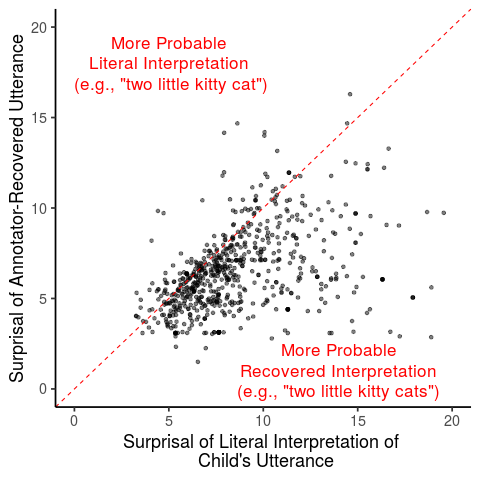

In [198]:
%%R
p1 = ggplot(p_caregiver_df) + geom_point(aes(y = annotator_recovery_p,
    x = highest_alt_recovery_p), alpha=.5) + geom_abline(y=0, slope=1, color='red', linetype='dashed'
) + coord_cartesian(xlim=c(0,20), ylim=c(0,20)) + theme_classic(base_size=18) + xlab(
"Surprisal of Literal Interpretation of \n Child's Utterance") + ylab(
'Surprisal of Annotator-Recovered Utterance') + annotate("text", x = 5, y = 18,
label = 'More Probable\nLiteral Interpretation\n (e.g., "two little kitty cat")', colour='red', size=6,
lineheight = 1) + annotate("text", 
x = 14, y = 1, label = 'More Probable\nRecovered Interpretation\n(e.g., "two little kitty cats")',
colour='red', size=6, lineheight = 1)

print(p1)
ggsave('figures/probability_under_models.png', width=6, height=6)
ggsave('figures/probability_under_models.pdf', width=6, height=6)

# Contingencies in Usage

In [75]:
# Possibly not representative of caregiver inference: 
     # 1) child uses a word, caregiver does not follow (could be relatively common for open class stuff)
# Representative of caregiver inference: 
    # 2) child uses a word, caregiver follows
    # 3) caregiver uses a word, child follows
    # 4) caregiver uses a word, child does not follow (this is not a case of child usage)
# need to specify a limit for the number of utterances to check against

In [77]:
#if we take the annotator-recovered tokens, how many do we see in cases 1, 2, and 3?
#annotator_recovered_tokens includes the utt_index as well as the xml_path

In [199]:
annotator_recovered_tokens.head()[['utt_index','xml_path']]

,utt_index,xml_path
0,143,011006.xml
0,364,011006.xml
0,394,011006.xml
3,468,011006.xml
1,962,011006.xml


In [200]:
# do I have utterance representations -- phono_token_df is a subset

In [201]:
annotator_recovered_tokens.shape

(7806, 20)

In [202]:
annotator_recovered_tokens.head(5)

,word_gloss,actual,model,preceding_gloss,transcribed_model_length_mismatch,spk,gloss,utt_index,citation_form_requires,actual_form_sz,age,child,xml_path,id,model_normalized,actual_normalized,model_in_cmu,actual_in_cmu,alternative_candidates,num_alt_candidates
0,six,ˈkik,ˈsɪks,[],False,CHI,six,143,True,0.0,677.0,Alex,011006.xml,0,ˈsɪks,ˈkik,True,False,"Series([], Name: ortho, dtype: object)",0
0,what's,wə,ˈwʌts,[],False,CHI,what's that,364,True,0.0,677.0,Alex,011006.xml,3,ˈwʌts,wə,True,False,"Series([], Name: ortho, dtype: object)",0
0,six,ˈɪː,ˈsɪks,[],False,CHI,six,394,True,0.0,677.0,Alex,011006.xml,4,ˈsɪks,ˈɪː,True,False,"Series([], Name: ortho, dtype: object)",0
3,this,ˈoˈno,ˈðɪs,"[oh, no, what's]",False,CHI,oh no what's this oh no,468,True,0.0,677.0,Alex,011006.xml,6,ˈðɪs,ˈoˈno,True,False,"Series([], Name: ortho, dtype: object)",0
1,this,,ˈðɪs,[what's],False,CHI,what's this,962,True,0.0,677.0,Alex,011006.xml,12,ˈðɪs,,True,False,"Series([], Name: ortho, dtype: object)",0


In [203]:
# process the phonemic transcripts and save them to a pickle

regenerate = True
parallel = True

imp.reload(PLEARN_phono_helper)
if regenerate:
    if parallel:
        all_utts = Parallel(n_jobs=os.cpu_count())(delayed(
            PLEARN_phono_helper.getArticulationProp)(x,False) for x in transcript_paths)
    else:
        all_utts = [PLEARN_phono_helper.getArticulationProp(x, False) for x in transcript_paths]
    all_utts_df = pd.concat([x for x in all_utts if x is not None])
    all_utts_df.to_pickle('pkl/providence_allutts.pkl')
else:
    all_utts_df = pd.read_pickle('pkl/providence_allutts.pkl')

In [204]:
all_utts_df.head(5)

,word_gloss,actual,model,preceding_gloss,transcribed_model_length_mismatch,spk,gloss,utt_index,age,child,xml_path
0,xxx,,,[],False,CHI,xxx,0,677.0,Alex,011006.xml
0,xxx,None,None,None,None,MOT,xxx let's go do the dishes,1,677.0,Alex,011006.xml
1,let's,None,None,None,None,MOT,xxx let's go do the dishes,1,677.0,Alex,011006.xml
2,go,None,None,None,None,MOT,xxx let's go do the dishes,1,677.0,Alex,011006.xml
3,do,None,None,None,None,MOT,xxx let's go do the dishes,1,677.0,Alex,011006.xml


In [205]:
all_utts_df.shape

(1826048, 11)

In [206]:
imp.reload(PLEARN_phono_helper)
PLEARN_phono_helper.getUsagePattern(all_utts_df, annotator_recovered_tokens.iloc[0], 30)

,num_following_tokens,num_preceding_tokens,other_following,other_preceding,utt_index,word,xml_path
0,44,92,True,False,143,six,011006.xml


In [271]:
imp.reload(PLEARN_phono_helper)
regenerate = False
parallel = False

if regenerate:
    if parallel:
        usage_patterns = Parallel(n_jobs=os.cpu_count())(delayed(
            PLEARN_phono_helper.getUsagePattern)(all_utts_df, 
            phono_token_df.iloc[i],
            30) for i in range(phono_token_df.shape[0]))
    else:        
        usage_patterns = [PLEARN_phono_helper.getUsagePattern(
            all_utts_df, 
            phono_token_df.iloc[i],
            30) for i in range(phono_token_df.shape[0])]
    usage_patterns_df = pd.concat(usage_patterns)
    usage_patterns_df.to_csv('csv/usage_patterns.csv', index=False)
else:
    usage_patterns_df = pd.read_csv('csv/usage_patterns.csv')
    

In [273]:
usage_patterns_df.head(10)

,id,num_following_tokens,num_preceding_tokens,other_following,other_preceding,utt_index,word,xml_path
0,0,44,92,True,False,143,six,011006.xml
0,1,86,41,False,False,169,what's,011006.xml
0,2,127,90,False,True,233,what's,011006.xml
0,3,71,71,False,False,364,what's,011006.xml
0,4,78,72,True,False,394,six,011006.xml
0,5,90,121,False,False,468,what's,011006.xml
0,6,90,121,False,True,468,this,011006.xml
0,7,82,105,False,False,655,what's,011006.xml
0,8,81,106,False,False,656,what's,011006.xml
0,9,113,99,False,False,815,what's,011006.xml


In [274]:
usage_patterns_df['used_in_context'] = np.logical_or(usage_patterns_df['other_preceding'],
    usage_patterns_df['other_following'])

In [275]:
np.mean(usage_patterns_df['used_in_context'])

0.6592424485861182

In [276]:
usage_patterns_df.shape

(49792, 9)

# Conservative Analysis: Only include if a caregiver uses the word within 30 utterances

### Analysis 1: Incidence of Caregiver-Recovered Tokens

In [280]:
usage_patterns_df.columns

Index(['id', 'num_following_tokens', 'num_preceding_tokens', 'other_following',
       'other_preceding', 'utt_index', 'word', 'xml_path', 'used_in_context'],
      dtype='object')

In [278]:
phono_token_df.shape

(49792, 14)

In [282]:
phono_token_df_aug = phono_token_df.merge(usage_patterns_df)
tokens_used_in_context = phono_token_df_aug.loc[phono_token_df_aug.used_in_context]
tokens_used_in_context.shape

(32825, 20)

In [286]:
tokens_used_in_context_short = tokens_used_in_context[['child','age','actual_form_sz',
    'gloss']]
%R -i tokens_used_in_context_short

In [288]:
%%R
head(tokens_used_in_context_short)

   child age actual_form_sz                   gloss before24 before18
0   Alex 677              0                     six     TRUE    FALSE
2   Alex 677              1             what's that     TRUE    FALSE
4   Alex 677              0                     six     TRUE    FALSE
6   Alex 677              0 oh no what's this oh no     TRUE    FALSE
10  Alex 677              1             what's that     TRUE    FALSE
13  Alex 677              0                     six     TRUE    FALSE
   before24_numeric tokens_used_in_context_short
0                -1                            1
2                -1                            1
4                -1                            1
6                -1                            1
10               -1                            1
13               -1                            1


In [289]:
%%R
library(lme4)
tokens_used_in_context_short$before24 = (tokens_used_in_context_short$age / 30.5)  < 24
tokens_used_in_context_short$before18 = (tokens_used_in_context_short$age / 30.5)  < 18
tokens_used_in_context_short$before24_numeric = -1
tokens_used_in_context_short$before24_numeric[tokens_used_in_context_short$before24] = 1
m2 <- glmer(
  actual_form_sz ~ before24_numeric + (before24_numeric | child), 
  data = tokens_used_in_context_short, 
  family = binomial(link = "logit")
)
summary(m2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: actual_form_sz ~ before24_numeric + (before24_numeric | child)
   Data: tokens_used_in_context_short

     AIC      BIC   logLik deviance df.resid 
 27811.5  27853.5 -13900.7  27801.5    32820 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3474  0.2987  0.4144  0.4586  0.7976 

Random effects:
 Groups Name             Variance Std.Dev. Corr
 child  (Intercept)      0.17813  0.4221       
        before24_numeric 0.03648  0.1910   0.61
Number of obs: 32825, groups:  child, 6

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       1.45637    0.17311   8.413  < 2e-16 ***
before24_numeric -0.26608    0.08092  -3.288  0.00101 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
befr24_nmrc 0.604 


In [ ]:
# Unclear what is the appropriate denominator. Really we need to start with all 50k 
# matches and mismatches and subset to those that have a word in context

### Analysis 2: Higher Probability of Recoveries under the Model?

In [290]:
#annotator recovered tokens with usage patterns
art_wup = annotator_recovered_tokens.merge(usage_patterns_df,
    on = ['id','utt_index','xml_path'])

In [291]:
art_wup

,word_gloss,actual,model,preceding_gloss,transcribed_model_length_mismatch,spk,gloss,utt_index,citation_form_requires,actual_form_sz,...,model_in_cmu,actual_in_cmu,alternative_candidates,num_alt_candidates,num_following_tokens,num_preceding_tokens,other_following,other_preceding,word,used_in_context
0,six,ˈkik,ˈsɪks,[],False,CHI,six,143,True,0.0,...,True,False,"Series([], Name: ortho, dtype: object)",0,44,92,True,False,six,True
1,what's,wə,ˈwʌts,[],False,CHI,what's that,364,True,0.0,...,True,False,"Series([], Name: ortho, dtype: object)",0,71,71,False,False,what's,False
2,six,ˈɪː,ˈsɪks,[],False,CHI,six,394,True,0.0,...,True,False,"Series([], Name: ortho, dtype: object)",0,78,72,True,False,six,True
3,this,ˈoˈno,ˈðɪs,"[oh, no, what's]",False,CHI,oh no what's this oh no,468,True,0.0,...,True,False,"Series([], Name: ortho, dtype: object)",0,90,121,False,True,this,True
4,this,,ˈðɪs,[what's],False,CHI,what's this,962,True,0.0,...,True,False,"Series([], Name: ortho, dtype: object)",0,76,65,False,False,this,False
5,six,kɪːk,ˈsɪks,[],False,CHI,six,965,True,0.0,...,True,False,"Series([], Name: ortho, dtype: object)",0,78,61,True,False,six,True
6,what's,,ˈwʌts,"[what's, that]",False,CHI,what's that what's that,1135,True,0.0,...,True,False,"Series([], Name: ortho, dtype: object)",0,133,66,False,False,what's,False
7,what's,,ˈwʌts,"[what's, that]",False,CHI,what's that what's,1143,True,0.0,...,True,False,"Series([], Name: ortho, dtype: object)",0,140,80,False,False,what's,False
8,what's,,ˈwʌts,"[what's, that, what's, that]",False,CHI,what's that what's that what's,1147,True,0.0,...,True,False,"Series([], Name: ortho, dtype: object)",0,147,88,False,False,what's,False
9,where's,ˈwɪ,ˈwɛɹz,[],False,CHI,where's the red,189,True,0.0,...,True,False,"Series([], Name: ortho, dtype: object)",0,78,94,False,False,where's,False


In [292]:
art_wup_short = art_wup.loc[art_wup.used_in_context][['id','used_in_context']]
%R -i art_wup_short

In [293]:
%%R
cu_p_caregiver_df = subset(p_caregiver_df, id %in% art_wup_short$id)

t.test(cu_p_caregiver_df$annotator_recovery_p,
       cu_p_caregiver_df$highest_alt_recovery_p,paired=TRUE)


	Paired t-test

data:  cu_p_caregiver_df$annotator_recovery_p and cu_p_caregiver_df$highest_alt_recovery_p
t = -15.828, df = 460, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.502079 -1.949417
sample estimates:
mean of the differences 
              -2.225748 



In [ ]:
# Annotator recovery is still much more probable under the model